In [ ]:
# Mount Google Colab

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd '/content/gdrive/My Drive/Masters_Thesis'


Mounted at /content/gdrive
/content/gdrive/My Drive/Masters_Thesis


In [ ]:
!pip install stepmix # library used to build LCA model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from stepmix.stepmix import StepMix

from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

np.random.seed(42)

In [ ]:
# Provide the filename of your Excel file
file_name = 'uu_preprocessed.xlsx'

# Read the Excel file into a pandas DataFrame
df = pd.read_excel(file_name)

#Splitting data into answers for work_styles test

In [ ]:
work_styles = df[df['maingroup'] == 'tests.workstyles.title']
len(work_styles.question_id.unique())

# Above gives: array(['Gerichtheid op mensen', 'Sociale invloed', 'Aanpassingsvermogen',
#       'Zorgvuldigheid', 'Praktisch inzicht', 'Prestatiegerichtheid',
#       'Onafhankelijkheid'], dtype=object)

#Is the same as:
# People orientation, Social influence, Adaptability, diligence, Practical insight, Performance orientation, Independence

16

In [ ]:
# Specify the column names you want to keep
columns_to_keep = ['question_id', 'maingroup', 'level1subgroup']

# Subset the DataFrame using the specified columns
wrk_s = work_styles.loc[:, columns_to_keep]

wrk_s = wrk_s.drop(['maingroup'], axis=1)
qs = wrk_s.drop_duplicates(subset='question_id')
qs = qs.sort_values('level1subgroup')
qs

# Create the 'short_name' column
qs['short_name'] = ''

# Same process as shown and explained in personality notebook
count_peo_o = 1
count_si = 1
count_a2 = 1
count_d2 = 1
count_pi = 1
count_per_o = 1
count_i3 = 1

for index, row in qs.iterrows():
    if row['level1subgroup'] == 'Gerichtheid op mensen':
        qs.at[index, 'short_name'] = f'peo{count_peo_o}'
        count_peo_o += 1

    elif row['level1subgroup'] == 'Sociale invloed':
        qs.at[index, 'short_name'] = f'sin{count_si}'
        count_si += 1

    elif row['level1subgroup'] == 'Aanpassingsvermogen':
        qs.at[index, 'short_name'] = f'ada{count_a2}'
        count_a2 += 1

    elif row['level1subgroup'] == 'Zorgvuldigheid':
        qs.at[index, 'short_name'] = f'dil{count_d2}'
        count_d2 += 1

    elif row['level1subgroup'] == 'Praktisch inzicht':
        qs.at[index, 'short_name'] = f'pin{count_pi}'
        count_pi += 1

    elif row['level1subgroup'] == 'Prestatiegerichtheid':
        qs.at[index, 'short_name'] = f'per{count_per_o}'
        count_per_o += 1

    else:
        qs.at[index, 'short_name'] = f'inde{count_i3}'
        count_i3 += 1

qs

,question_id,level1subgroup,short_name
132,2406,Aanpassingsvermogen,ada1
133,2405,Aanpassingsvermogen,ada2
134,2404,Aanpassingsvermogen,ada3
128,2403,Gerichtheid op mensen,peo1
129,2402,Gerichtheid op mensen,peo2
130,2401,Gerichtheid op mensen,peo3
143,2410,Onafhankelijkheid,inde1
138,2412,Praktisch inzicht,pin1
139,2411,Praktisch inzicht,pin2
140,2397,Prestatiegerichtheid,per1


In [ ]:
n_qs = qs.drop(['level1subgroup'], axis=1)

# merging (left join) studeies to orginal dataframe
new_qs = pd.merge(work_styles, n_qs, on='question_id', how='left')
new_qs.head(3)

,dossier_id,question_id,answer,label,maingroup,maingroup_id,level1subgroup,level1subgroup_id,faculty,short_name
0,1532,2403,1.0,Om mijn werk goed te doen is het belangrijk om...,tests.workstyles.title,516.0,Gerichtheid op mensen,526,Faculteit Betawetenschappen,peo1
1,1532,2402,0.8,Om mijn werk goed te doen is het belangrijk om...,tests.workstyles.title,516.0,Gerichtheid op mensen,526,Faculteit Betawetenschappen,peo2
2,1532,2401,1.0,Om mijn werk goed te doen is het belangrijk om...,tests.workstyles.title,516.0,Gerichtheid op mensen,526,Faculteit Betawetenschappen,peo3


In [ ]:
# Create pivot table for Questions
qs_data = pd.pivot_table(new_qs, values='answer', index='dossier_id', columns='short_name')

# Reset the index of 'qs_data'
qs_data = qs_data.reset_index()
qs_data = qs_data.rename_axis(None, axis=1)

# Remove NAN values
qs_data.replace('', np.nan, inplace=True)
qs_data = qs_data.dropna()
qs_data

,dossier_id,ada1,ada2,ada3,dil1,dil2,dil3,inde1,peo1,peo2,peo3,per1,per2,per3,pin1,pin2,sin1
0,1532,0.4,0.8,1.0,1.0,0.8,1.0,0.4,1.0,0.8,1.0,0.4,0.8,0.6,1.0,0.6,0.6
1,1649,0.8,0.6,0.8,1.0,0.6,0.4,0.4,0.6,0.8,1.0,0.2,0.6,0.4,0.8,0.6,0.4
2,2112,0.6,0.8,0.2,0.8,0.4,0.4,0.6,0.8,0.8,1.0,0.2,0.8,0.8,0.8,0.8,0.8
3,30690,0.6,0.6,0.6,0.8,0.8,0.8,0.4,0.8,0.4,0.6,0.8,0.6,0.8,0.8,0.6,0.8
4,42388,0.6,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.6,0.6,0.4,0.6,0.6,1.0,0.8,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,91848,0.8,0.8,0.8,1.0,0.8,1.0,0.6,1.0,1.0,0.8,0.6,0.6,0.8,0.6,0.8,0.6
393,91894,0.6,0.8,1.0,0.8,0.8,1.0,0.8,0.6,0.6,0.8,0.6,0.8,0.8,0.8,0.6,0.6
394,91927,0.6,0.6,0.8,1.0,0.8,0.8,0.6,0.6,0.8,0.8,0.6,0.8,0.6,0.6,0.6,0.6
395,91928,1.0,1.0,0.8,1.0,0.6,0.8,0.8,0.6,0.6,1.0,0.8,0.8,0.8,0.8,1.0,0.6


In [ ]:
model = qs_data.drop('dossier_id', axis=1)
model
# Collect data for LCA before possible K-Means manipulation
data_lca = model

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

# creating X variable to use as to not effect the model data
X = model

# range of cluster numbers to test
n_clusters_range = range(2, 10)
wcss = [] # wcss metric to collect enertia values for elbow method

# dictionaries to store the metrics
metrics = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': [],
    'n_clusters': []
}

# Loop over the cluster numbers and perform clustering
for i, n_clusters in enumerate(n_clusters_range):

    # Run hierarchical clustering using the ward linkage method
    ward_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    ward_cluster.fit(X)

    #Extract the labels and linkage matrix
    ward_labels = ward_cluster.labels_
    linkage_matrix = ward_cluster.children_

    # Extract the cluster centroids from the linkage matrix
    centroids = []
    for j in range(n_clusters):
        indices = ward_labels == j
        centroid = X[indices].mean(axis=0)
        centroids.append(centroid)
    kmeans_cluster = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=0)
    kmeans_cluster.fit(X)
    cluster_labels = kmeans_cluster.labels_

    # Calculate the metrics for the current cluster assignment
    inertia = kmeans_cluster.inertia_
    silhouette = silhouette_score(X, kmeans_cluster.labels_)
    calinski_harabasz = calinski_harabasz_score(X, kmeans_cluster.labels_)
    davies_bouldin = davies_bouldin_score(X, kmeans_cluster.labels_)

    # Store the metrics in the dictionary
    metrics['silhouette'].append(silhouette)
    metrics['calinski_harabasz'].append(calinski_harabasz)
    metrics['davies_bouldin'].append(davies_bouldin)
    metrics['n_clusters'].append(n_clusters)
    wcss.append(kmeans_cluster.inertia_)

# Convert the metrics dictionary to dataframe
metrics_df = pd.DataFrame(metrics)

metrics_df

,silhouette,calinski_harabasz,davies_bouldin,n_clusters
0,0.133565,64.466605,2.388160,2
1,0.099988,51.487920,2.469842,3
2,0.085677,42.857579,2.416013,4
3,0.079871,37.627540,2.381990,5
4,0.075905,34.554935,2.296063,6
5,0.069922,30.740112,2.362650,7
6,0.065353,28.122173,2.424462,8
7,0.061760,26.138974,2.454355,9


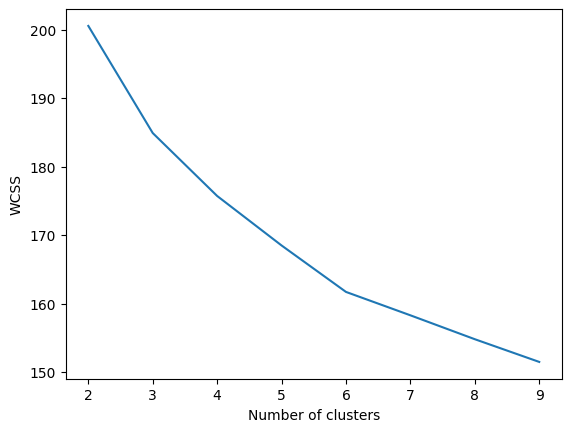

In [ ]:
# Plot Elbow
plt.plot(n_clusters_range, wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

<Axes: xlabel='PC1', ylabel='PC2'>

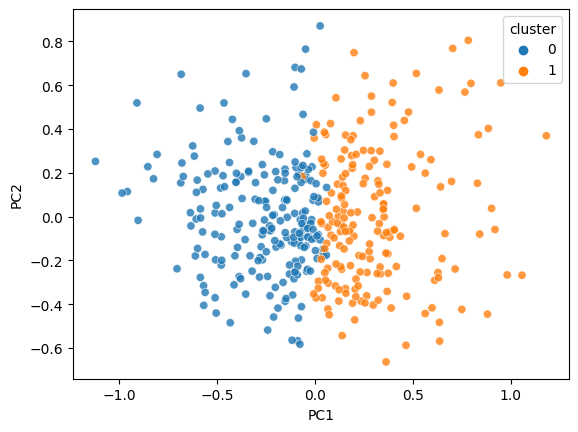

In [ ]:
# Create K-Means Cluster Model
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA

seed = 1234 # Used for reproducibility

kmeans = KMeans(n_clusters=2, n_init = 10, random_state=seed)
k_fit = kmeans.fit(model)
centroids = kmeans.cluster_centers_
predictions = k_fit.labels_

# Develop 2 PCA components for visualizations
pca = PCA(2)
pca_data = pd.DataFrame(pca.fit_transform(model),columns=['PC1','PC2'])

pca_data['cluster'] = pd.Categorical(predictions)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data, palette='tab10', alpha=0.8)

In [ ]:
pca_data.to_excel('before_work_s_clusters.xlsx', index=False) # to be used for comparison in personality notebook

#Latent Class Analysis

In [ ]:
from sklearn.model_selection import ParameterGrid
# Create LCA model
model = StepMix(n_components=3, measurement="categorical", verbose=1, random_state=123, n_init=10)

grid = {
    'n_components': [2, 3, 4, 5, 6, 7, 8, 9],
    'n_steps' : [1]
}

results = dict(param_n_steps=[], param_n_components=[], aic=[], bic=[])


# Same model and grid as above
for g in ParameterGrid(grid):
    model.set_params(**g)
    model.fit(data_lca)
    results['param_n_components'].append(g['n_components'])
    results['aic'].append(model.aic(data_lca))
    results['bic'].append(model.bic(data_lca))

# Save results to a dataframe
results = pd.DataFrame(results)

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 13.49it/s, max_LL=-2.86e+3, max_avg_LL=-7.23]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 17 features, each with 6 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 6 are associated with the first feature,
        columns 7 to 12 are associated with the second feature, etc.

        Class 1 : [0.6639 0.3361 0.0000 0.0000 0.0000 0.0000 0.5696 0.4304 0.0000 0.0000
 0.0000 0.0000 0.5343 0.4657 0.0000 0.0000 0.0000 0.0000 0.3000 0.7000
 0.0000 0.0000 0.0000 0.0000 0.4694 0.5306 0.0000 0.0000 0.0000 0.0000
 0.3939 0.6061 0.0000 0.0000 0.0000 0.0000 0.8542 0.1458 0.0000 0.0000
 0.0000 0.0000 0.5266 0.4734 0.0000 0.0000 0.0000 0.0000 0.7108 0.2892
 0.0000 0.0000 0.0000 0.0000 0.3775 0.6225 0.0000 0.0000 0.0000 0.0000
 0.7519 0.2481 0.0000 0.0000 0.0000 0.0000 0.6232 0.3768 0.0000 0.0000
 0.0000 0.0000 0.5357 0.4643 0.0000 0.0000 0.0000 0.0000 0.7217 0.2783


Initializations (n_init) : 100%|██████████| 10/10 [00:04<00:00,  2.11it/s, max_LL=-2.8e+3, max_avg_LL=-7.06]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 17 features, each with 6 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 6 are associated with the first feature,
        columns 7 to 12 are associated with the second feature, etc.

        Class 1 : [0.9714 0.0286 0.0000 0.0000 0.0000 0.0000 0.9733 0.0267 0.0000 0.0000
 0.0000 0.0000 0.9699 0.0301 0.0000 0.0000 0.0000 0.0000 0.8567 0.1433
 0.0000 0.0000 0.0000 0.0000 0.8988 0.1012 0.0000 0.0000 0.0000 0.0000
 0.8891 0.1109 0.0000 0.0000 0.0000 0.0000 0.8997 0.1003 0.0000 0.0000
 0.0000 0.0000 0.9805 0.0195 0.0000 0.0000 0.0000 0.0000 0.9925 0.0075
 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000
 0.9447 0.0553 0.0000 0.0000 0.0000 0.0000 0.8662 0.1338 0.0000 0.0000
 0.0000 0.0000 0.9543 0.0457 0.0000 0.0000 0.0000 0.0000 0.8353 0.1647


Initializations (n_init) : 100%|██████████| 10/10 [00:07<00:00,  1.28it/s, max_LL=-2.74e+3, max_avg_LL=-6.93]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 17 features, each with 6 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 6 are associated with the first feature,
        columns 7 to 12 are associated with the second feature, etc.

        Class 1 : [0.6489 0.3511 0.0000 0.0000 0.0000 0.0000 0.5377 0.4623 0.0000 0.0000
 0.0000 0.0000 0.5037 0.4963 0.0000 0.0000 0.0000 0.0000 0.2779 0.7221
 0.0000 0.0000 0.0000 0.0000 0.4568 0.5432 0.0000 0.0000 0.0000 0.0000
 0.3911 0.6089 0.0000 0.0000 0.0000 0.0000 0.8443 0.1557 0.0000 0.0000
 0.0000 0.0000 0.5092 0.4908 0.0000 0.0000 0.0000 0.0000 0.7172 0.2828
 0.0000 0.0000 0.0000 0.0000 0.3457 0.6543 0.0000 0.0000 0.0000 0.0000
 0.7471 0.2529 0.0000 0.0000 0.0000 0.0000 0.6046 0.3954 0.0000 0.0000
 0.0000 0.0000 0.4992 0.5008 0.0000 0.0000 0.0000 0.0000 0.7132 0.2868


Initializations (n_init) : 100%|██████████| 10/10 [00:14<00:00,  1.46s/it, max_LL=-2.7e+3, max_avg_LL=-6.82]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 17 features, each with 6 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 6 are associated with the first feature,
        columns 7 to 12 are associated with the second feature, etc.

        Class 1 : [0.9330 0.0670 0.0000 0.0000 0.0000 0.0000 0.9747 0.0253 0.0000 0.0000
 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.8894 0.1106
 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000
 0.9178 0.0822 0.0000 0.0000 0.0000 0.0000 0.9890 0.0110 0.0000 0.0000
 0.0000 0.0000 0.8035 0.1965 0.0000 0.0000 0.0000 0.0000 0.8690 0.1310
 0.0000 0.0000 0.0000 0.0000 0.7266 0.2734 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.9412 0.0588 0.0000 0.0000
 0.0000 0.0000 0.9552 0.0448 0.0000 0.0000 0.0000 0.0000 0.9205 0.0795


Initializations (n_init) : 100%|██████████| 10/10 [00:12<00:00,  1.22s/it, max_LL=-2.67e+3, max_avg_LL=-6.74]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 17 features, each with 6 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 6 are associated with the first feature,
        columns 7 to 12 are associated with the second feature, etc.

        Class 1 : [0.9642 0.0358 0.0000 0.0000 0.0000 0.0000 0.9702 0.0298 0.0000 0.0000
 0.0000 0.0000 0.9538 0.0462 0.0000 0.0000 0.0000 0.0000 0.8053 0.1947
 0.0000 0.0000 0.0000 0.0000 0.8501 0.1499 0.0000 0.0000 0.0000 0.0000
 0.8558 0.1442 0.0000 0.0000 0.0000 0.0000 0.8732 0.1268 0.0000 0.0000
 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000
 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000
 0.9193 0.0807 0.0000 0.0000 0.0000 0.0000 0.8708 0.1292 0.0000 0.0000
 0.0000 0.0000 0.9496 0.0504 0.0000 0.0000 0.0000 0.0000 0.8442 0.1558


Initializations (n_init) : 100%|██████████| 10/10 [00:21<00:00,  2.19s/it, max_LL=-2.65e+3, max_avg_LL=-6.7]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 17 features, each with 6 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 6 are associated with the first feature,
        columns 7 to 12 are associated with the second feature, etc.

        Class 1 : [0.9442 0.0558 0.0000 0.0000 0.0000 0.0000 0.9609 0.0391 0.0000 0.0000
 0.0000 0.0000 0.9211 0.0789 0.0000 0.0000 0.0000 0.0000 0.7457 0.2543
 0.0000 0.0000 0.0000 0.0000 0.9500 0.0500 0.0000 0.0000 0.0000 0.0000
 0.7825 0.2175 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 0.9802 0.0198 0.0000 0.0000 0.0000 0.0000 0.9242 0.0758
 0.0000 0.0000 0.0000 0.0000 0.8475 0.1525 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.9828 0.0172 0.0000 0.0000
 0.0000 0.0000 0.9666 0.0334 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000


Initializations (n_init) : 100%|██████████| 10/10 [00:25<00:00,  2.53s/it, max_LL=-2.64e+3, max_avg_LL=-6.67]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 17 features, each with 6 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 6 are associated with the first feature,
        columns 7 to 12 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.9759 0.0241 0.0000 0.0000
 0.0000 0.0000 0.9518 0.0482 0.0000 0.0000 0.0000 0.0000 0.8333 0.1667
 0.0000 0.0000 0.0000 0.0000 0.8495 0.1505 0.0000 0.0000 0.0000 0.0000
 0.8606 0.1394 0.0000 0.0000 0.0000 0.0000 0.8676 0.1324 0.0000 0.0000
 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000
 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000
 0.9278 0.0722 0.0000 0.0000 0.0000 0.0000 0.8777 0.1223 0.0000 0.0000
 0.0000 0.0000 0.9639 0.0361 0.0000 0.0000 0.0000 0.0000 0.8359 0.1641


Initializations (n_init) : 100%|██████████| 10/10 [00:27<00:00,  2.78s/it, max_LL=-2.62e+3, max_avg_LL=-6.62]

MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 17 features, each with 6 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 6 are associated with the first feature,
        columns 7 to 12 are associated with the second feature, etc.

        Class 1 : [0.7712 0.2288 0.0000 0.0000 0.0000 0.0000 0.4207 0.5793 0.0000 0.0000
 0.0000 0.0000 0.6843 0.3157 0.0000 0.0000 0.0000 0.0000 0.4463 0.5537
 0.0000 0.0000 0.0000 0.0000 0.7593 0.2407 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.4861 0.5139 0.0000 0.0000
 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000
 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000
 0.6958 0.3042 0.0000 0.0000 0.0000 0.0000 0.6657 0.3343 0.0000 0.0000
 0.0000 0.0000 0.5226 0.4774 0.0000 0.0000 0.0000 0.0000 0.7054 0.2946


In [ ]:
results.drop('param_n_steps', axis = 1 ).round()

,param_n_components,aic,bic
0,2,6115.0,6883.0
1,3,6174.0,7328.0
2,4,6260.0,7801.0
3,5,6369.0,8296.0
4,6,6502.0,8816.0
5,7,6664.0,9363.0
6,8,6831.0,9916.0
7,9,6986.0,10458.0
